# Blood Cell Image Classification

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [2]:
# Preliminary check for available devices for TensorFlow
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15920506976618183832, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6700198133
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6367164308058535440
 physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"]

### Image preprocessing

(240, 320, 3)


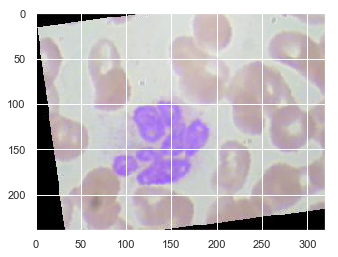

In [3]:
img = load_img("dataset2-master/images/TRAIN/EOSINOPHIL/_0_207.jpeg")
x = img_to_array(img)
#x = x.reshape((1,) + x.shape)
plt.imshow(x/255.) # Note: imshow() expects input to be 0-1 range, this is needs to be rescale
print(x.shape)

**Observation:** Images are 320 x 240 pixels. May be worth considering to resize the images for training.

The source of the data already divided the images into TRAIN and TEST folders. Take advantage of this setup and use the Image class from Keras. From that class, one can use the ImageDataGenerator method to split the images in the TRAIN folder by training and validation sets very easily. 

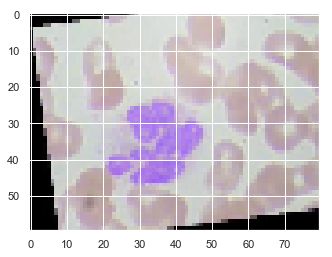

In [4]:
x = cv2.resize(x, (80,60))
plt.imshow(x/255.)

In [5]:
x.shape

(60, 80, 3)

#### Data Augmentation

In [6]:
train_IDG = ImageDataGenerator(
        rotation_range = 25,      # Random rotations (degrees, 0 to 180)
        width_shift_range = 0.1,  # Random horizontal shifts on image (fraction of total width)
        height_shift_range = 0.1, # Random vertical shifts on image (fraction of total height)
        horizontal_flip = True,   # Random flip on images
        vertical_flip = False,
        rescale = 1./255,
        validation_split = 0.2
)

test_IDG = ImageDataGenerator(rescale = 1./255)

In [7]:
set_dir = 'dataset2-master/images/TRAIN'
test_dir = 'dataset2-master/images/TEST'
tar_dim = (60, 80) # Dimension of resized target image (adjustable)

training_gen = train_IDG.flow_from_directory(
    subset = 'training',
    shuffle = True,
    batch_size = 32,
    target_size = tar_dim,
    directory = set_dir
)

validation_gen = train_IDG.flow_from_directory(
    subset = 'validation',
    shuffle = True,
    batch_size = 32,
    target_size = tar_dim,
    directory = set_dir
)

test_gen = test_IDG.flow_from_directory(
    directory = test_dir,
    shuffle = False,
    target_size = tar_dim
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


In [8]:
nClasses = len(test_gen.class_indices)

## Neural network training

In [9]:
def plot_keras_metrics(hist):
    '''Given the history of the Keras training model,
       plot the loss and accuracy.
    '''
    train_acc = hist.history['acc']
    train_loss = hist.history['loss']

    val_acc = hist.history['val_acc']
    val_loss = hist.history['val_loss']
    figure(figsize=(10,10))
    plt.subplot(211)
    plt.plot(train_loss, label='Training')
    plt.plot(val_loss, '--', label='Validation')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.subplot(212)
    plt.plot(train_acc)
    plt.plot(val_acc, '--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Source: sklearn
    """
    plt.rcParams["axes.grid"] = False
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    fig, ax = plt.subplots(figsize=(6,6))
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #    print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
# Some parameters for the model
step_size_train = training_gen.n // training_gen.batch_size + 1
step_size_valid = validation_gen.n // validation_gen.batch_size + 1
step_size_test  = test_gen.n // test_gen.batch_size + 1

### Model 1: Conv2D (3x) + Dropout

Start with a relatively simple convnet. The [image classifier tutorial](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) in Kera is a good starting point. 

In [12]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3,3), strides = (1, 1), activation = 'relu',input_shape = (60, 80, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size = (3,3), strides = (1, 1), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size = (3,3), strides = (1, 1), activation = 'relu'))
# the model so far outputs 3D feature maps (height, width, features)

model.add(Flatten())
model.add(Dense(64))
model.add(Dropout(0.25))
model.add(Dense(nClasses, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adadelta', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 58, 78, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 39, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 37, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 18, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 16, 64)        18496     
_________________________________________________________________
flatten_1 (Flatten)  

**Observations**:
- 'adam' as an optimizer is not a good choice.
- Optimizer alternatives that works well: rmsprop, adadelta.
- Needs more than one conv. layer.
- Without dropouts, training and validation accuracy is in the 90% range.

In [13]:
model_history = model.fit_generator(
    training_gen,
    steps_per_epoch = step_size_train,
    validation_data = validation_gen,
    validation_steps = step_size_valid,
    epochs = 35,
    verbose = 0
)

model.save_weights('model1.h5')

Instructions for updating:
Use tf.cast instead.


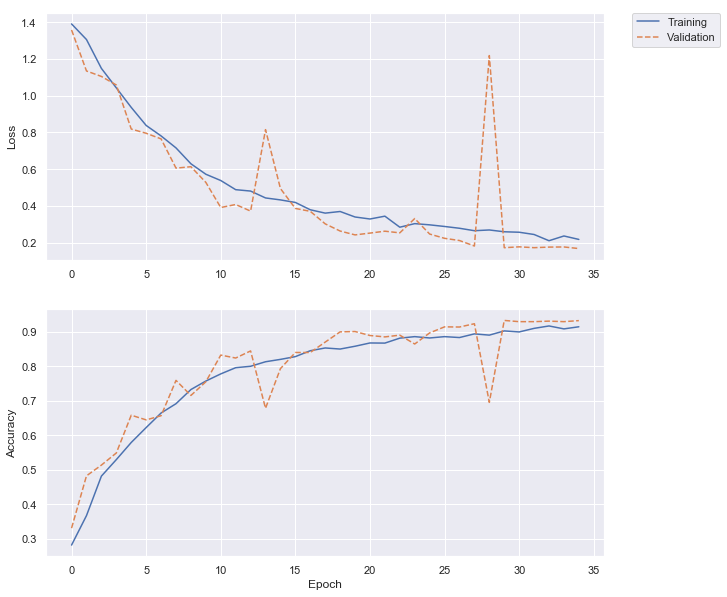

In [14]:
plot_keras_metrics(model_history)

In [15]:
test_gen.reset()
score = model.evaluate_generator(test_gen, steps=step_size_test)
print("Test Accuracy = ",score[1])

Test Accuracy =  0.8315239243350165


A different way to compute test accuracy(?)

In [16]:
test_gen.reset()
y_predict = model.predict_generator(test_gen, steps=step_size_test)
y_predict = np.argmax(y_predict, axis = 1)

y_test = test_gen.classes[test_gen.index_array]

In [17]:
sum(y_predict==y_test)/len(y_test)

0.8315239244069159

In [18]:
class_names = list(test_gen.class_indices.keys())
print('\n', classification_report(y_test, y_predict, target_names=class_names), sep='')   


              precision    recall  f1-score   support

  EOSINOPHIL       0.76      0.75      0.76       623
  LYMPHOCYTE       1.00      0.99      0.99       620
    MONOCYTE       0.98      0.75      0.85       620
  NEUTROPHIL       0.66      0.84      0.74       624

   micro avg       0.83      0.83      0.83      2487
   macro avg       0.85      0.83      0.84      2487
weighted avg       0.85      0.83      0.84      2487



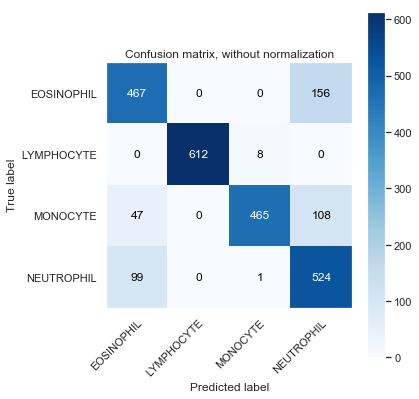

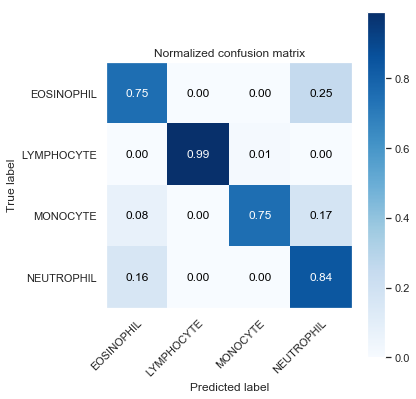

In [19]:
plot_confusion_matrix(y_test,y_predict,class_names)
plot_confusion_matrix(y_test,y_predict,class_names,normalize=True)

**Observations**:
- Validation loss is decreasing together with training loss. No hints of severe overfitting/underfitting.
- Test score for this model is about 83%.
- Classification report shows that the model has a high precision and recall for labeling an image as LYMPHOCYTE (i.e., correctly recognized with little false positives).
- Model has a low precision and high recall for labeling an image as NEUTROPHIL (i.e., Positive samples that are correctly recognized but lots of false positives). This is more apparent with its F-score (i.e., predictive power), being the lowest of all the labels. 
- Overall, it is interesting to see that this model can obtain a training/validation accuracy of over 90% in a little over 30 epochs. Perhaps the original images don't have too many distinct features that can be extracted, which makes them somewhat easier to train on.

### Visualize CNN Layers

In [20]:
x = x.reshape((1,)+x.shape)         # Reshape image from above
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(x)

In [30]:
def show_activation(activations, col_size, row_size, act_index): 
    '''
        Display the activation values computed from Keras.
        Only shows the values corresponding the layer of index 'act_index'.
        
        Source: https://www.codeastar.com/visualize-convolutional-neural-network/
    '''
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*8.5))
    plt.rcParams["axes.grid"] = False
    
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='cubehelix')
            ax[row][col].axis('off')
            activation_index += 1

Look at output from the first layer:

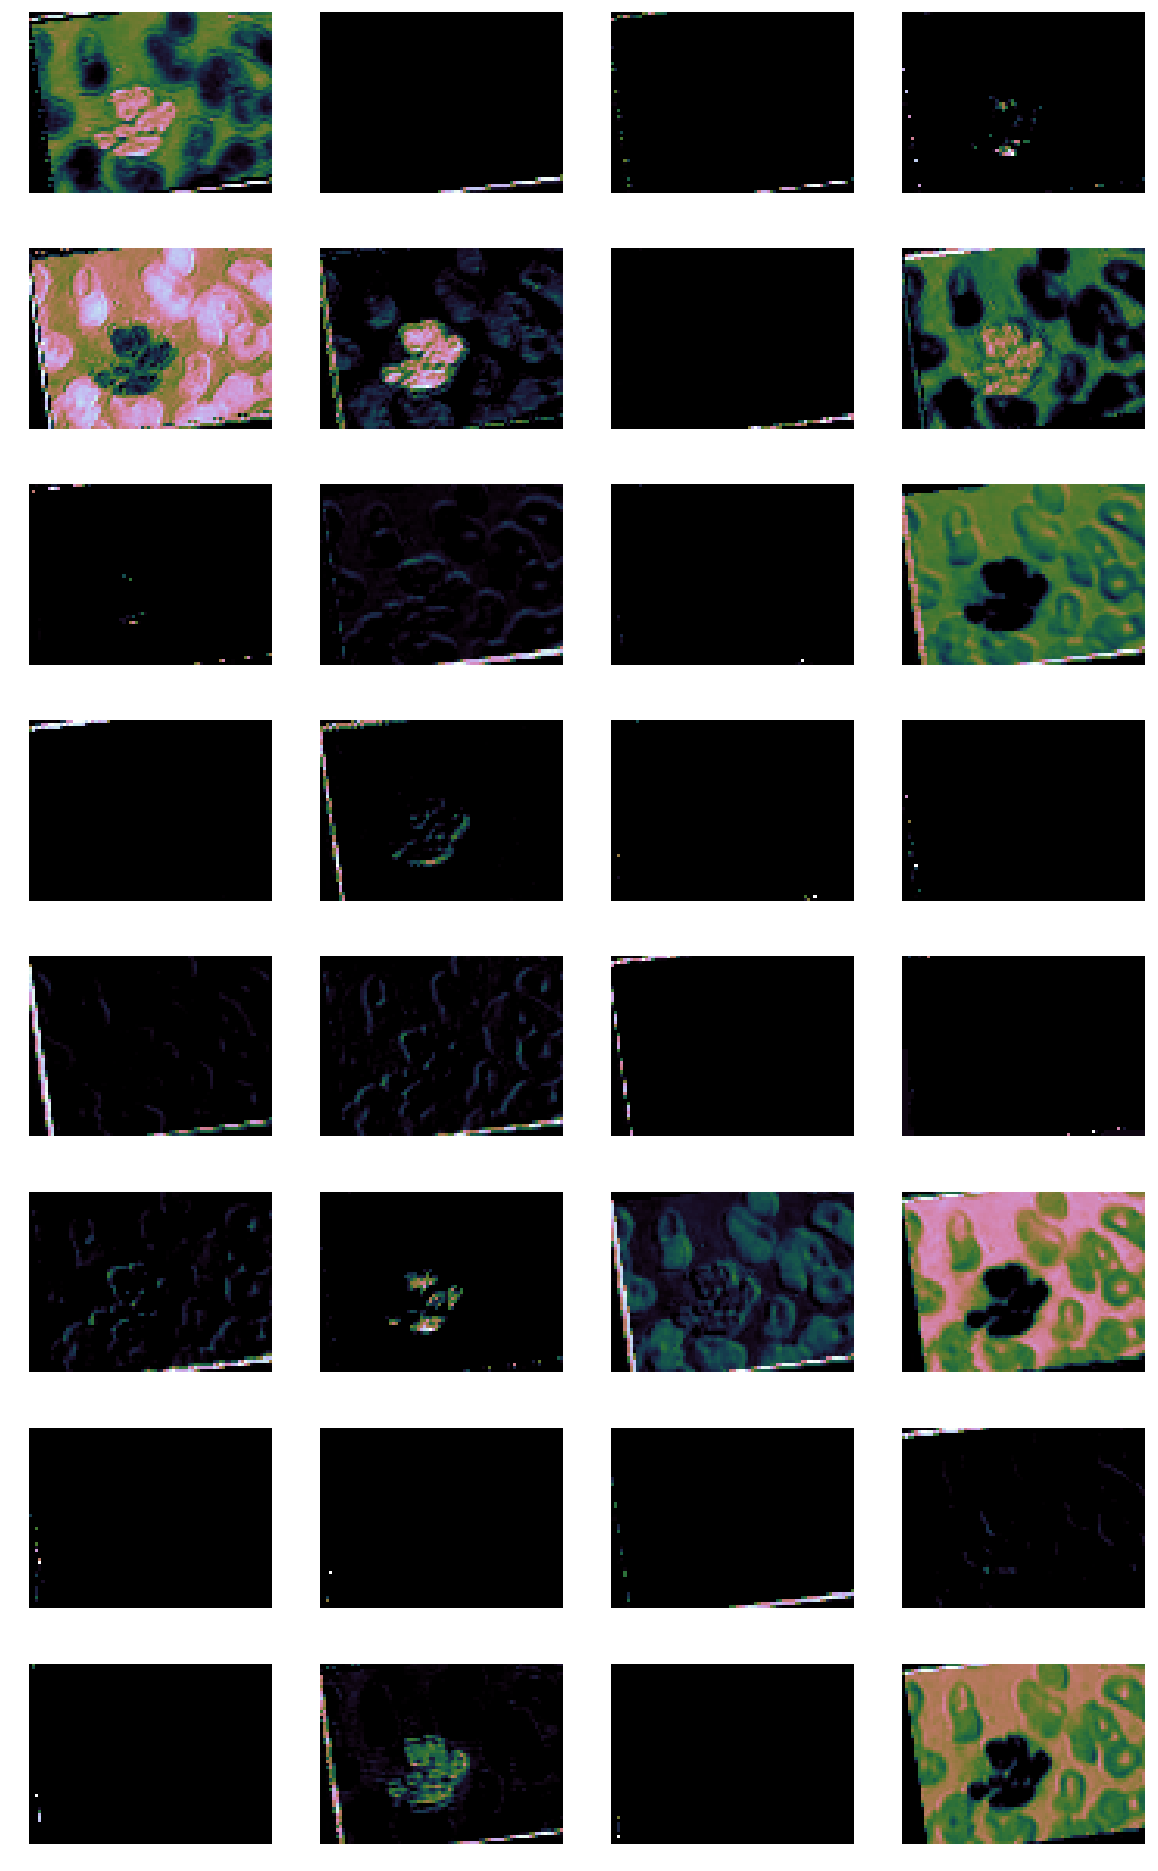

In [31]:
show_activation(activations, 4, 8, 0)

**Observations**:
- Some features appear indiscernible/not very useful as it was speculated above. One could reduce the number of features in the Conv2D layer(s) to get a better model.